In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product


from resnet_model.utils.data_loading import *
from resnet_model.utils.helpers_train import *
from resnet_model.tools.plot import *
from analysis_helpers import *

In [2]:
path_df = 'colour_ants.csv'
images_dir = '/Volumes/T7 Shield/AntProject/original'

df = pd.read_csv(path_df)
df.head()

,specimen,original_file,species,x_head,y_head,x_thorax,y_thorax,x_abdomen,y_abdomen,r_head,...,r_thorax,g_thorax,b_thorax,r_abdomen,g_abdomen,b_abdomen,max_distance,file_head,file_thorax,file_abdomen
0,casent0280684,casent0280684_p_1.jpg,Acanthognathus brevicornis,541.761428,611.801353,710.781834,634.915325,1186.833259,449.712645,108,...,82,37,16,91,52,21,15.64,casent0280684_p_1_head.png,casent0280684_p_1_thorax.png,casent0280684_p_1_abdomen.png
1,casent0914659,casent0914659_p_1.jpg,Acanthognathus brevicornis,343.088620,585.595543,569.682016,656.890638,1071.440567,336.927097,119,...,118,74,37,166,129,77,26.18,casent0914659_p_1_head.png,casent0914659_p_1_thorax.png,casent0914659_p_1_abdomen.png
2,usnment00445715,usnment00445715_p_1.jpg,Acanthognathus lentus,401.710873,565.733114,689.236409,515.149918,859.621911,256.909390,226,...,203,149,75,206,164,88,30.90,usnment00445715_p_1_head.png,usnment00445715_p_1_thorax.png,usnment00445715_p_1_abdomen.png
3,casent0178718,casent0178718_p_1.jpg,Acanthognathus ocellatus,161.119440,600.342669,318.193575,661.574959,898.569193,390.023064,153,...,113,69,40,149,105,58,18.46,casent0178718_p_1_head.png,casent0178718_p_1_thorax.png,casent0178718_p_1_abdomen.png
4,casent0914660,casent0914660_p_1.jpg,Acanthognathus ocellatus,477.114498,653.588138,796.587315,637.614498,1116.060132,339.439868,142,...,107,68,29,110,68,28,17.92,casent0914660_p_1_head.png,casent0914660_p_1_thorax.png,casent0914660_p_1_abdomen.png


### Looking at preformance of baseline resnet model vs resnet model
Plotting training and validation loss for baseline resnet model and the performance for the resnet with an additional layer. This model has been hypertuned and the performance during hypertuning is plotted.

In [3]:
folder_path_run = 'resnet_model/results/hypertuning_runs'
sorted_file_paths = read_sort_json_file_names(folder_path_run)

folder_path_run_baseline = 'resnet_model/results/hypertuning_runs/baseline'
baseline_file_path = read_sort_json_file_names(folder_path_run_baseline)

In [4]:
val_loss = get_loss(sorted_file_paths)

val_loss_baseline = get_loss(baseline_file_path)

In [5]:
#Defining hyperparameters used
hparam_space = {
            "batch_size": [512,256],
            "lr": [0.001, 0.0001],
            "nodes": [128, 256, 512]
        }

# Generate combinations of hyperparameters
keys, values = zip(*hparam_space.items())
hparam_combinations = [dict(zip(keys, v)) for v in product(*values)]

In [6]:
results_val = {}
# Extract hyperparameters
for i,hparams in enumerate(hparam_combinations):
    batch_size = hparams["batch_size"]
    learning_rate = hparams["lr"]
    nodes = hparams["nodes"]

    # Store the results using a tuple key
    results_val[(learning_rate, batch_size, nodes)] = val_loss[i]

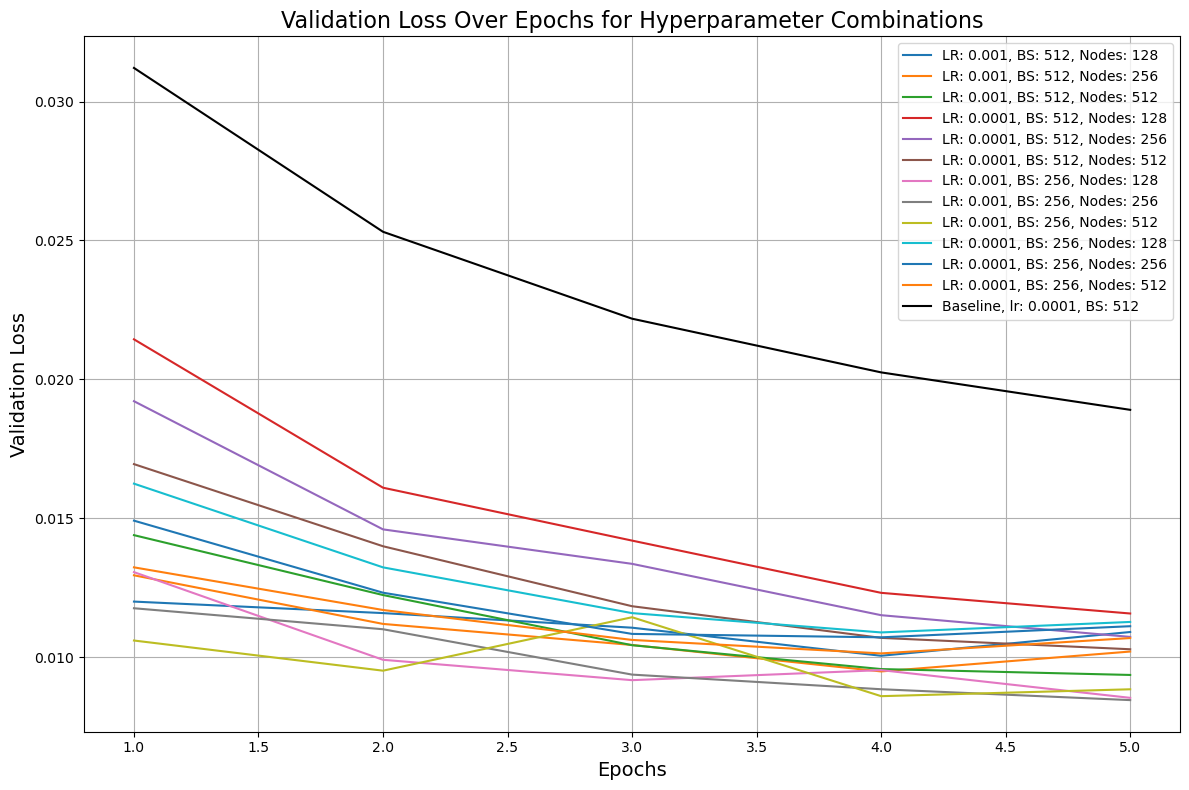

In [7]:
plt.figure(figsize=(12, 8))

for (lr, batch_size, nodes), losses in results_val.items():
    epochs = range(1, len(losses) + 1)  
    label = f"LR: {lr}, BS: {batch_size}, Nodes: {nodes}"
    plt.plot(epochs, losses, label=label)

plt.plot(epochs,val_loss_baseline[0], color='black', label='Baseline, lr: 0.0001, BS: 512')

# Add labels, legend, and title
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Validation Loss", fontsize=14)
plt.title("Validation Loss Over Epochs for Hyperparameter Combinations", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

### Loading in best preforming model and evaluating it further
The best preforming model from hyperparameter tuning is the model with batch size 256, nodes in hidden layer 256 and a learning rate of 0.001.

### Model for predicting Thorax

In [8]:
#Reading in best preforming model target and output colors
file_path_target = "resnet_model/output_training/run_2024-12-11_10-16-35/target_colors/target_colors_model1.pkl"
target_colors_thorax = open_pickle(file_path_target)

file_path_output = "resnet_model/output_training/run_2024-12-11_10-16-35/output_colors/output_colors_model1.pkl"
output_colors_thorax  = open_pickle(file_path_output)

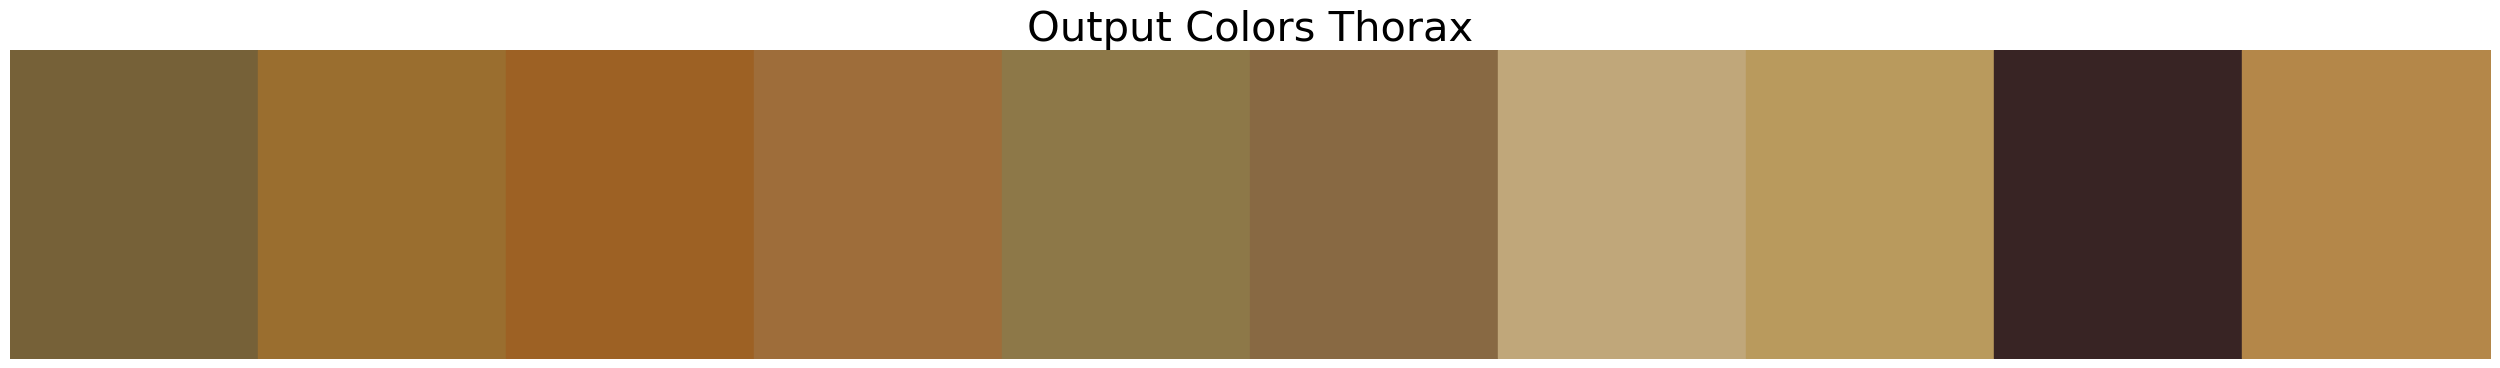

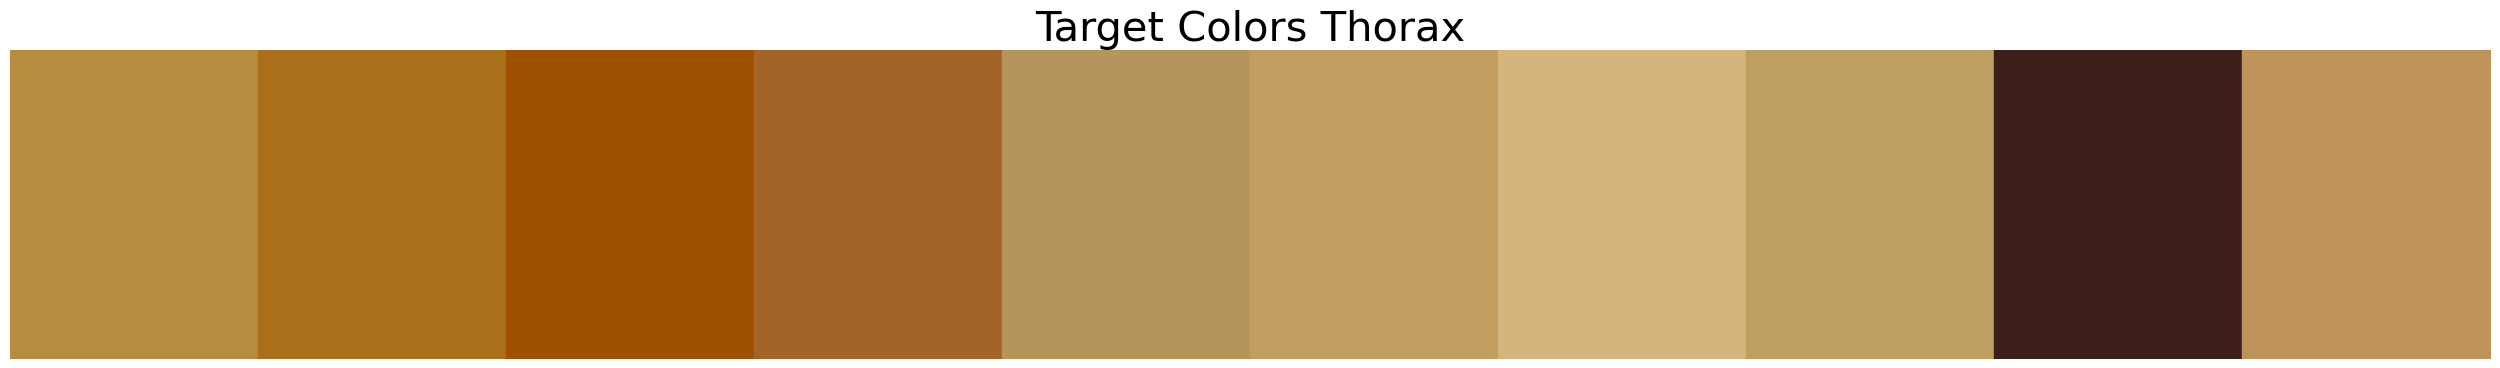

In [9]:
# Thorax prediction for the 10 first images in batch 0
plot_rgb_blocks(convert(output_colors_thorax[0]), "Output Colors Thorax",max_colors = 10)
plot_rgb_blocks(convert(target_colors_thorax[0]), "Target Colors Thorax",max_colors = 10)

### Plot evaluation matrics

In [10]:
loss_thorax = calulate_MSE_loss(target_colors_thorax,output_colors_thorax)

print('Final validation loss Thorax', round(loss_thorax.item() / len(target_colors_thorax), 4))

Final validation loss Thorax 0.0084


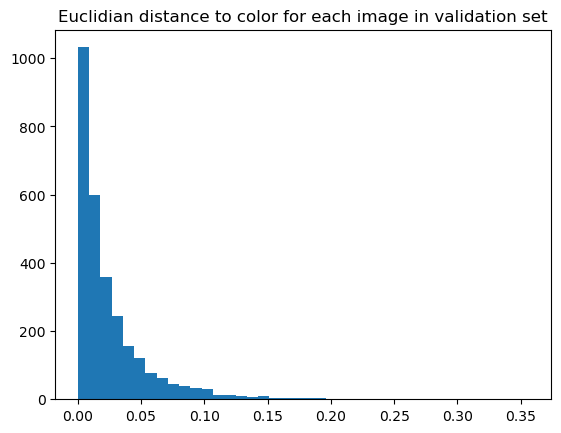

In [11]:
target_colors_array_thorax = convert_tensor_in_batch_to_numpy(target_colors_thorax)
output_colors_array_thorax = convert_tensor_in_batch_to_numpy(output_colors_thorax)

euclidian_distance_thorax = np.sum((target_colors_array_thorax - output_colors_array_thorax)** 2, axis = 1)

plt.hist(euclidian_distance_thorax, bins = 40)
#plt.yscale('log')
plt.title('Euclidian distance to color for each image in validation set')
plt.show()

In [12]:
#Sorted euclidian distance
ed_sorted_index_thorax = np.argsort(euclidian_distance_thorax)
ed_sorted_thorax = np.sort(euclidian_distance_thorax)

In [13]:
lowest_10_indices_thorax = ed_sorted_index_thorax[:10]
highest_10_indices_thorax = ed_sorted_index_thorax[-10:]

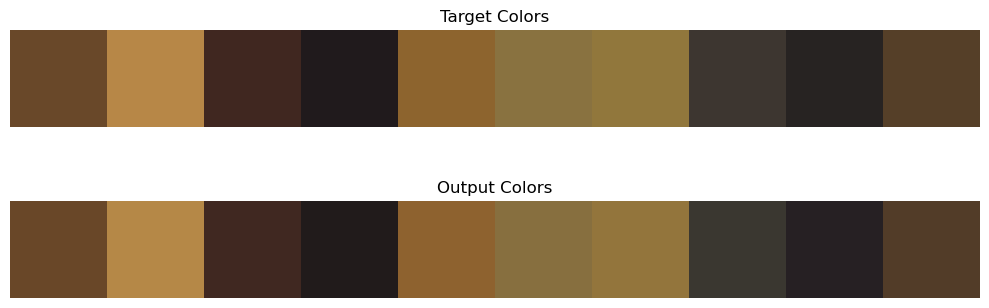

In [14]:
#Plot best predicted colors using euclidian distance
plot_colors_with_subplots(target_colors_array_thorax, output_colors_array_thorax, lowest_10_indices_thorax)

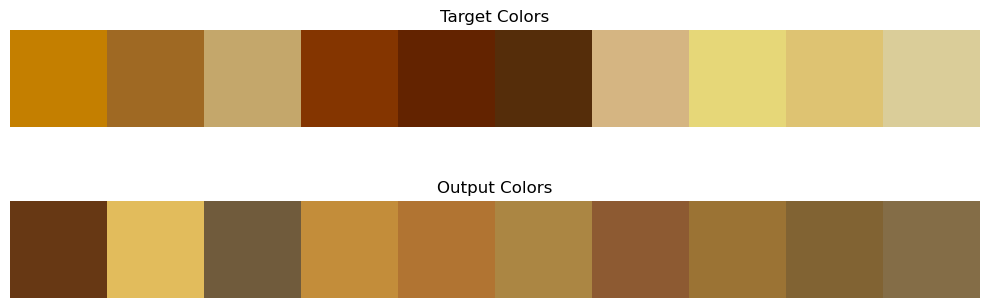

In [15]:
#Plot worst predicted colors using euclidian distance
plot_colors_with_subplots(target_colors_array_thorax, output_colors_array_thorax, highest_10_indices_thorax)

### Models for predicting color of Abdomen
RGB values where changed to abdomen for the best preforming model batch size 256, number of nodes 256 and learning rate 0.01

In [16]:
#Reading in best preforming model target and output colors
file_path_target = "resnet_model/output_training/run_2024-12-17_00-55-52_abdo/target_colors/abdomen_target_colors.pkl"
target_colors_abdomen = open_pickle(file_path_target)

file_path_output = "resnet_model/output_training/run_2024-12-17_00-55-52_abdo/output_colors/abdomen_output_colors.pkl"
output_colors_abdomen = open_pickle(file_path_output)

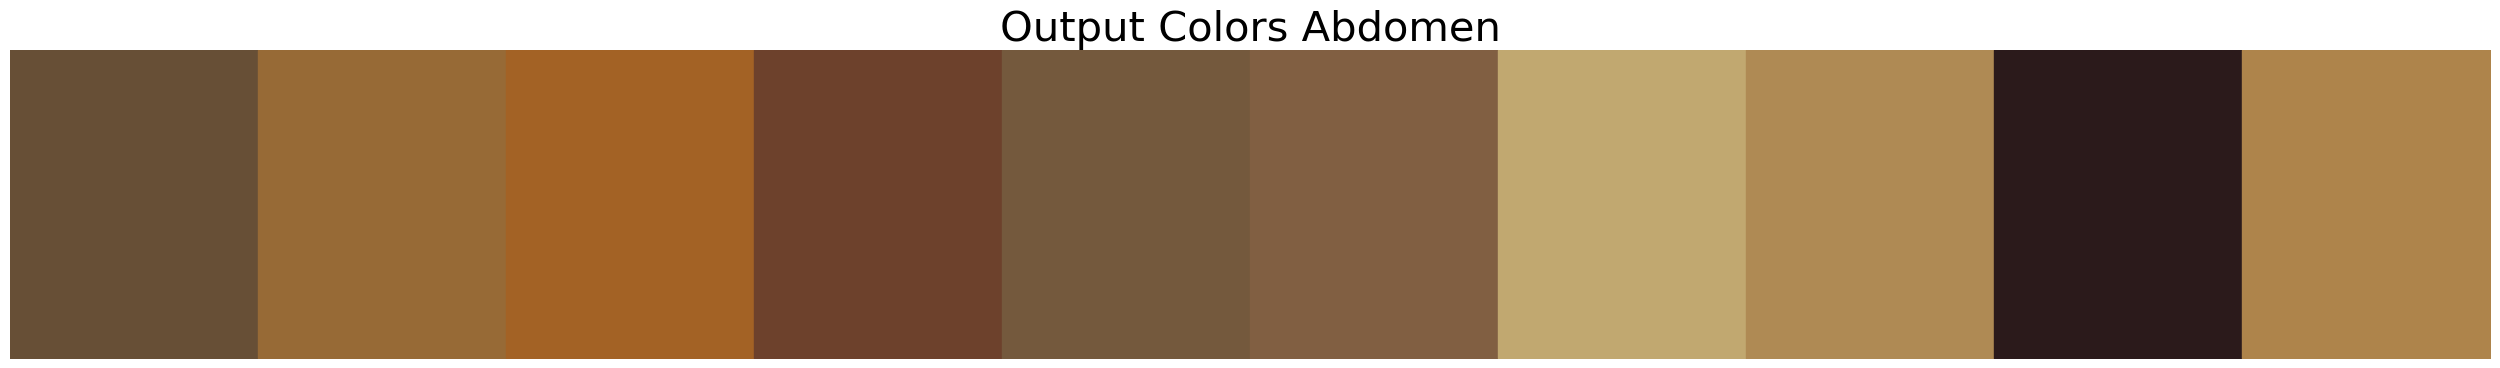

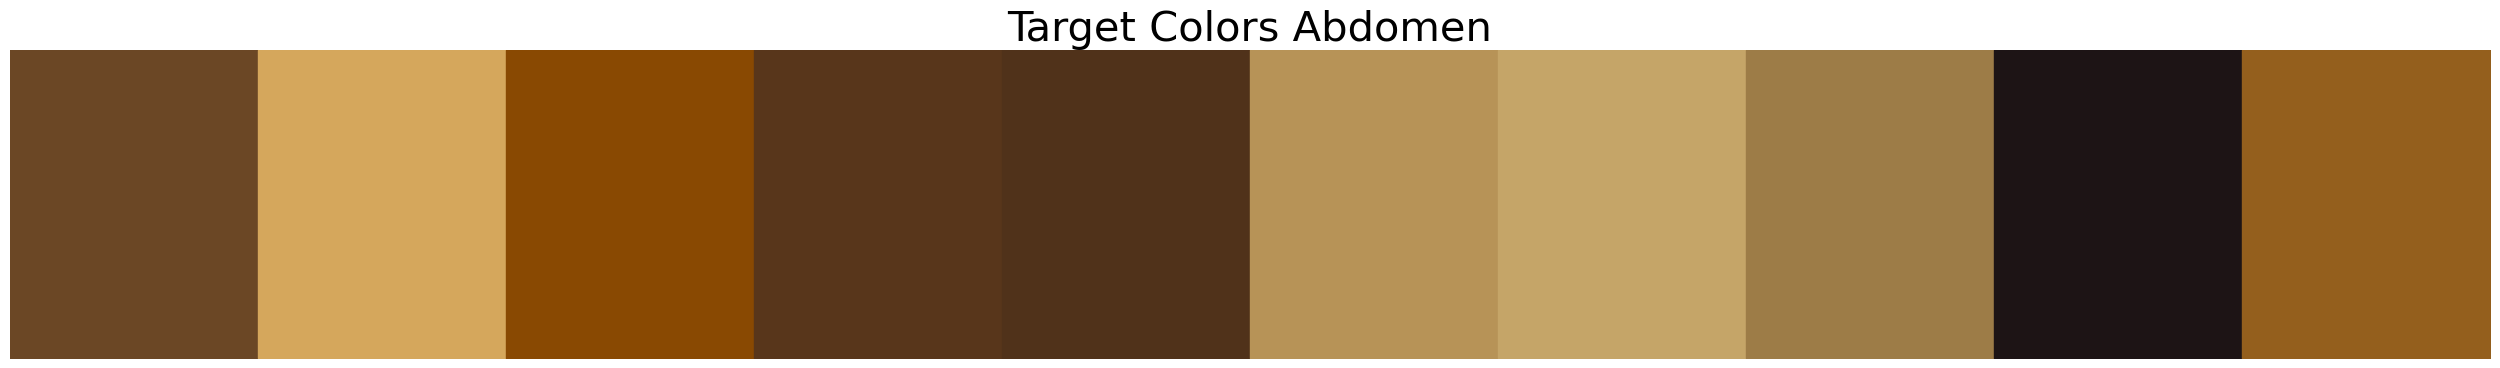

In [17]:
# Plot output and target color
plot_rgb_blocks(convert(output_colors_abdomen[0]), "Output Colors Abdomen",max_colors = 10)
plot_rgb_blocks(convert(target_colors_abdomen[0]), "Target Colors Abdomen",max_colors = 10)

In [18]:
loss_abdomen = calulate_MSE_loss(target_colors_abdomen,output_colors_abdomen)

print('Final validation loss Abdomen', round(loss_abdomen.item() / len(target_colors_abdomen), 4))

Final validation loss Abdomen 0.0102


### Models for predicting color of Head
RGB values where changed to abdomen for the best preforming model batch size 256, number of nodes 256 and learning rate 0.01

In [19]:
#Reading in best preforming model target and output colors
file_path_target = "resnet_model/output_training/run_2024-12-16_16-33-27_head/target_colors/head_target_colors.pkl"
target_colors_head = open_pickle(file_path_target)

file_path_output ="resnet_model/output_training/run_2024-12-16_16-33-27_head/output_colors/head_output_colors.pkl"
output_colors_head = open_pickle(file_path_output)

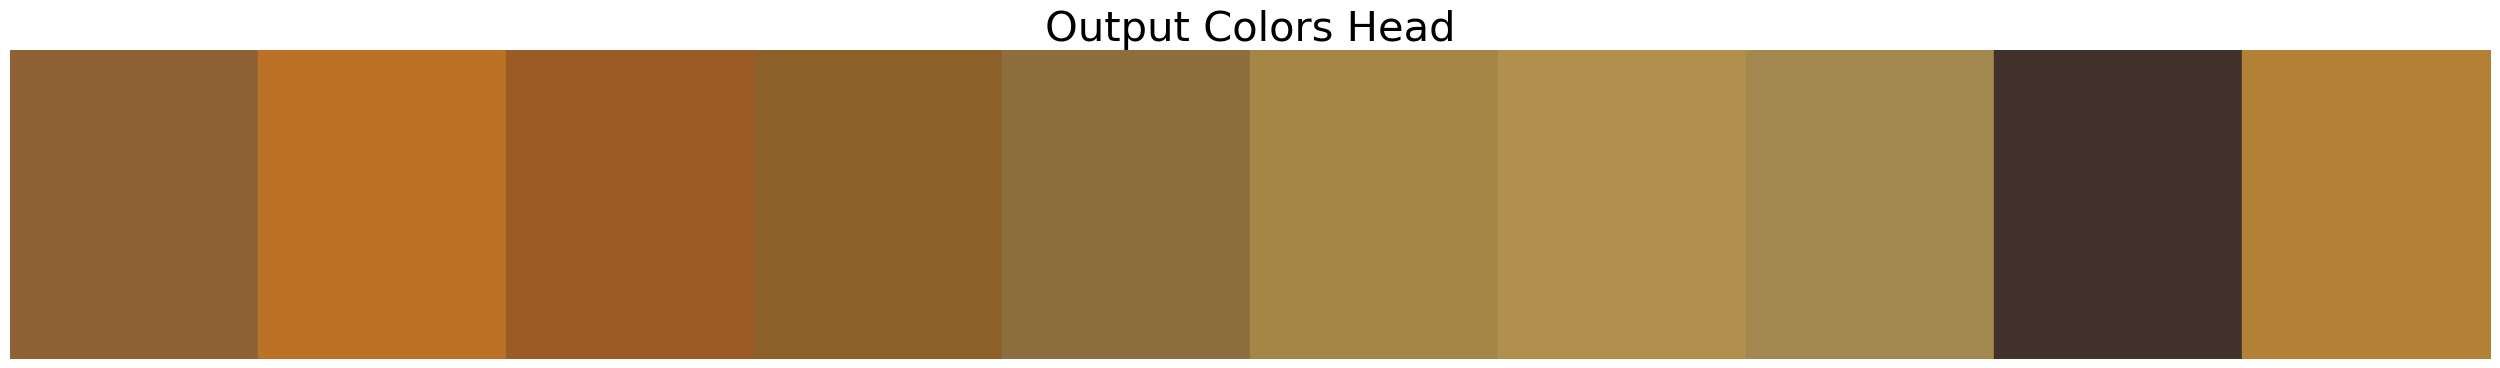

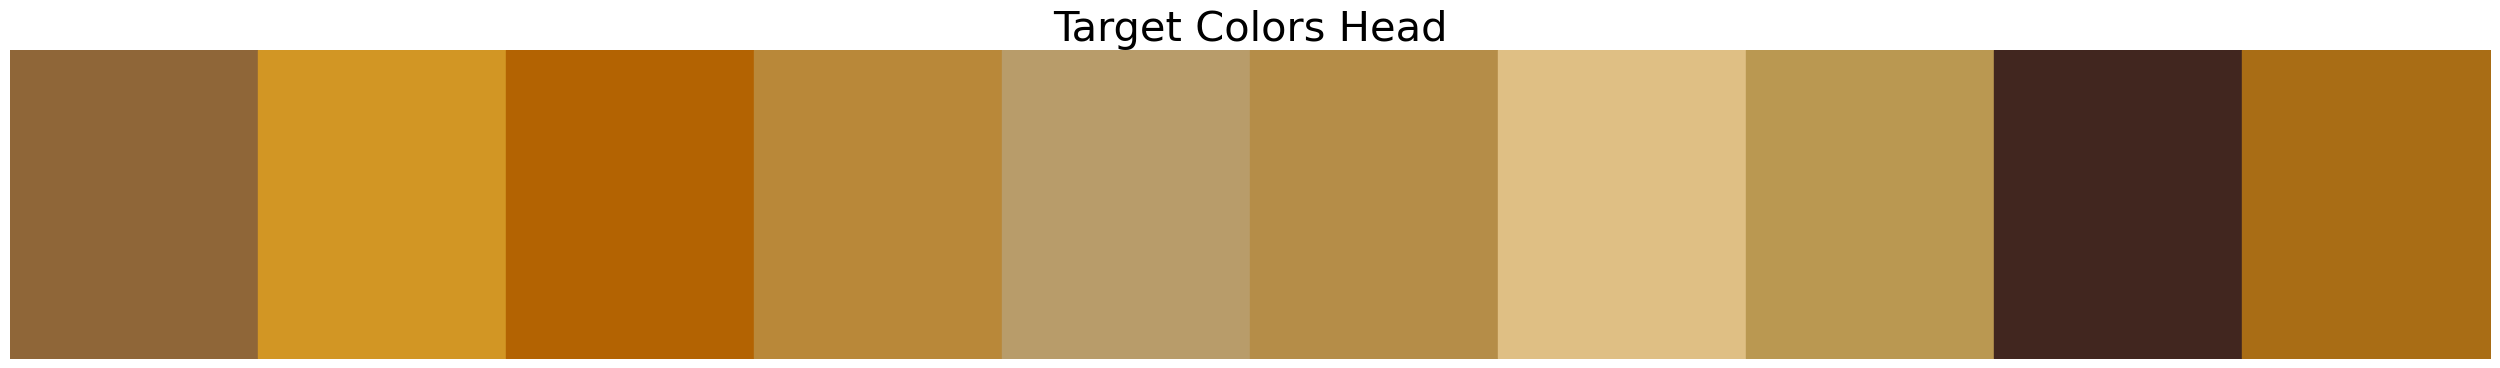

In [20]:
# Plot output and target color
plot_rgb_blocks(convert(output_colors_head[0]), "Output Colors Head",max_colors = 10)
plot_rgb_blocks(convert(target_colors_head[0]), "Target Colors Head",max_colors = 10)


In [21]:
loss_head = calulate_MSE_loss(target_colors_head,output_colors_head)

print('Final validation loss Head', round(loss_head.item() / len(target_colors_head), 4))

Final validation loss Head 0.0088


### Comparing preformance using Euclidian distance distribution
Euclidian distance distribution is used to compare preformance between models

In [22]:
target_colors_array_thorax = convert_tensor_in_batch_to_numpy(target_colors_thorax)
output_colors_array_thorax = convert_tensor_in_batch_to_numpy(output_colors_thorax)

euclidian_distance_thorax = np.sum((target_colors_array_thorax - output_colors_array_thorax)** 2, axis = 1)

target_colors_array_head = convert_tensor_in_batch_to_numpy(target_colors_head)
output_colors_array_head = convert_tensor_in_batch_to_numpy(output_colors_head)

euclidian_distance_head = np.sum((target_colors_array_head - output_colors_array_head)** 2, axis = 1)

target_colors_array_abdomen = convert_tensor_in_batch_to_numpy(target_colors_abdomen)
output_colors_array_abdomen = convert_tensor_in_batch_to_numpy(output_colors_abdomen)

euclidian_distance_abdomen = np.sum((target_colors_array_abdomen - output_colors_array_abdomen)** 2, axis = 1)

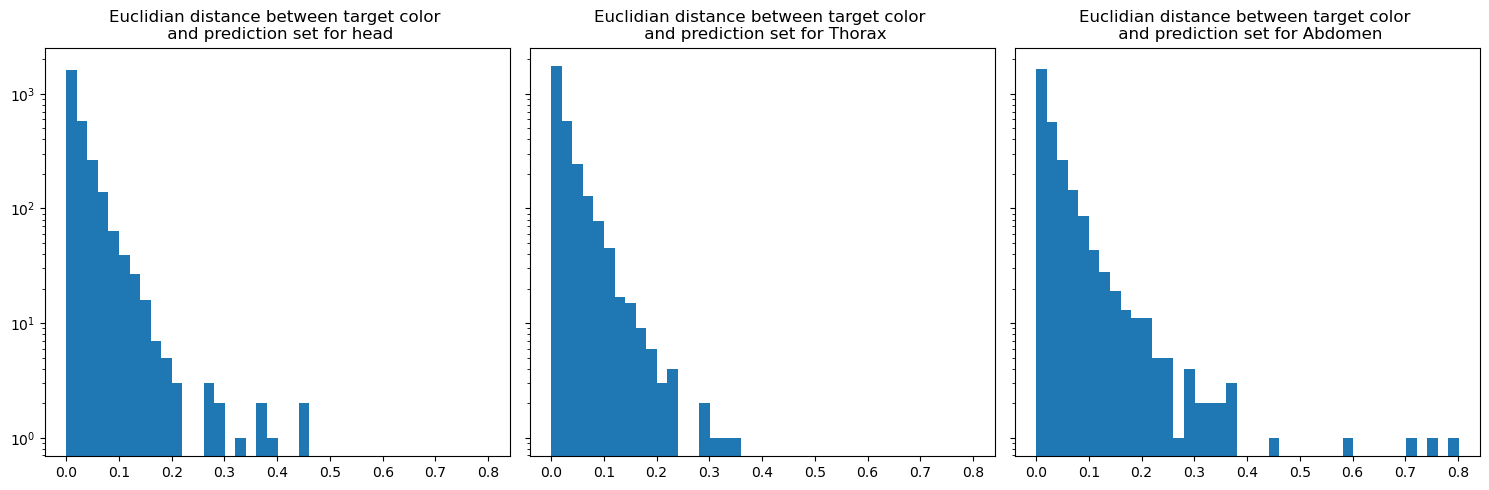

In [39]:
num_bins = 40

# Calculate the bin edges based on the global range of dataset
min_val = min(np.min(euclidian_distance_thorax), np.min(euclidian_distance_abdomen), np.min(euclidian_distance_head))
max_val = max(np.max(euclidian_distance_thorax), np.max(euclidian_distance_abdomen), np.max(euclidian_distance_head))

# Create equally spaced bins
bins = np.linspace(min_val, max_val, num_bins+1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Plot for Head
axs[0].hist(euclidian_distance_head, bins=bins)
axs[0].set_title('Euclidian distance between target color \n and prediction set for head')
axs[0].set_yscale('log')

# Plot for Thorax
axs[1].hist(euclidian_distance_thorax, bins=bins)
axs[1].set_title('Euclidian distance between target color \n and prediction set for Thorax')
axs[1].set_yscale('log')

# Plot for Abdomen
axs[2].hist(euclidian_distance_abdomen, bins=bins)
axs[2].set_title('Euclidian distance between target color \n and prediction set for Abdomen')
axs[2].set_yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()

### Segment model Thorax

In [27]:
#Thorax
file_path_target = "/Users/lisavind/Desktop/Model_zoomed/target_colors_thorax.pkl"
target_colors_thorax_zoomed = open_pickle(file_path_target)

file_path_output = "/Users/lisavind/Desktop/Model_zoomed/output_colors_thorax.pkl"
output_colors_thorax_zoomed = open_pickle(file_path_output)

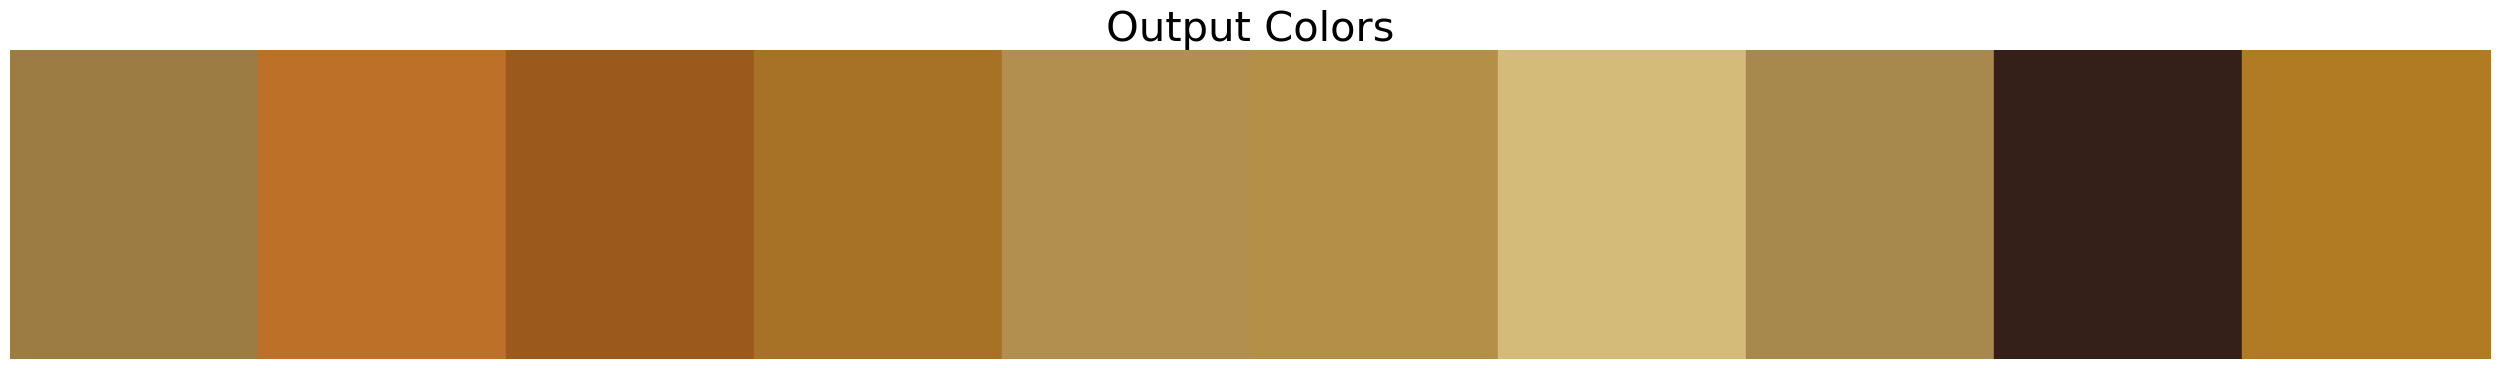

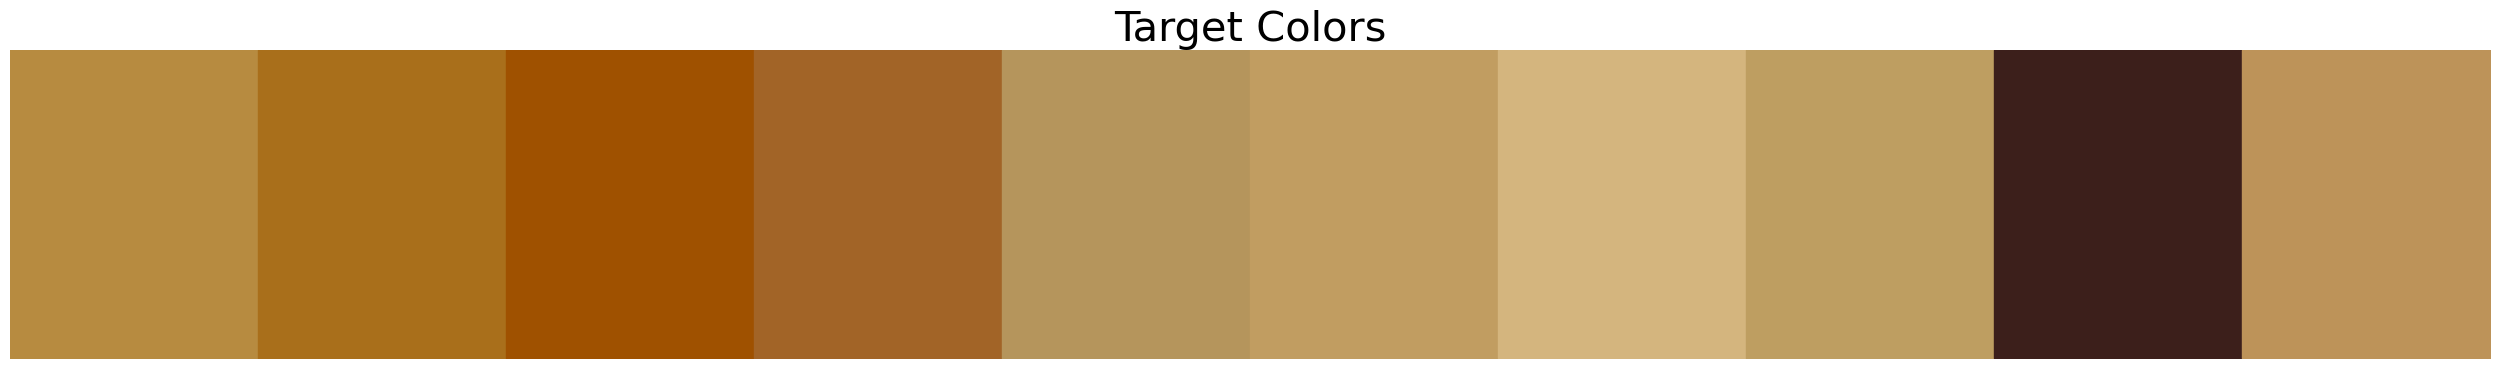

In [28]:
# Plot output and target color
plot_rgb_blocks(convert(output_colors_thorax_zoomed[0]), "Output Colors",max_colors = 10)
plot_rgb_blocks(convert(target_colors_thorax_zoomed[0]), "Target Colors",max_colors = 10)

In [29]:
loss_thorax_zoomed = calulate_MSE_loss(target_colors_thorax_zoomed,output_colors_thorax_zoomed)

print('Final validation loss Thorax', round(loss_thorax_zoomed.item() / len(target_colors_thorax_zoomed), 4))

Final validation loss Thorax 0.0063


### Segment model Head

In [31]:
#Head
file_path_target = "/Users/lisavind/Desktop/Model_zoomed/target_colors_head.pkl"
target_colors_head_zoomed = open_pickle(file_path_target)

file_path_output = "/Users/lisavind/Desktop/Model_zoomed/output_colors_head.pkl"
output_colors_head_zoomed = open_pickle(file_path_output)

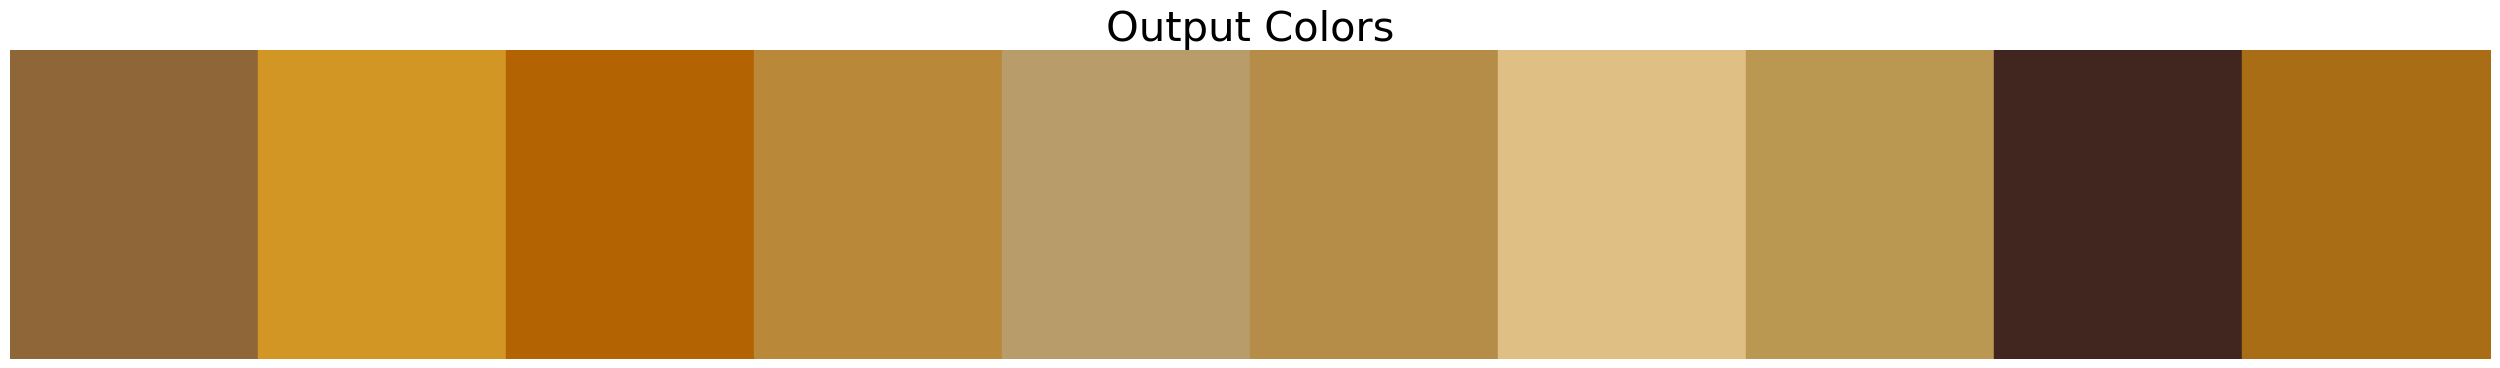

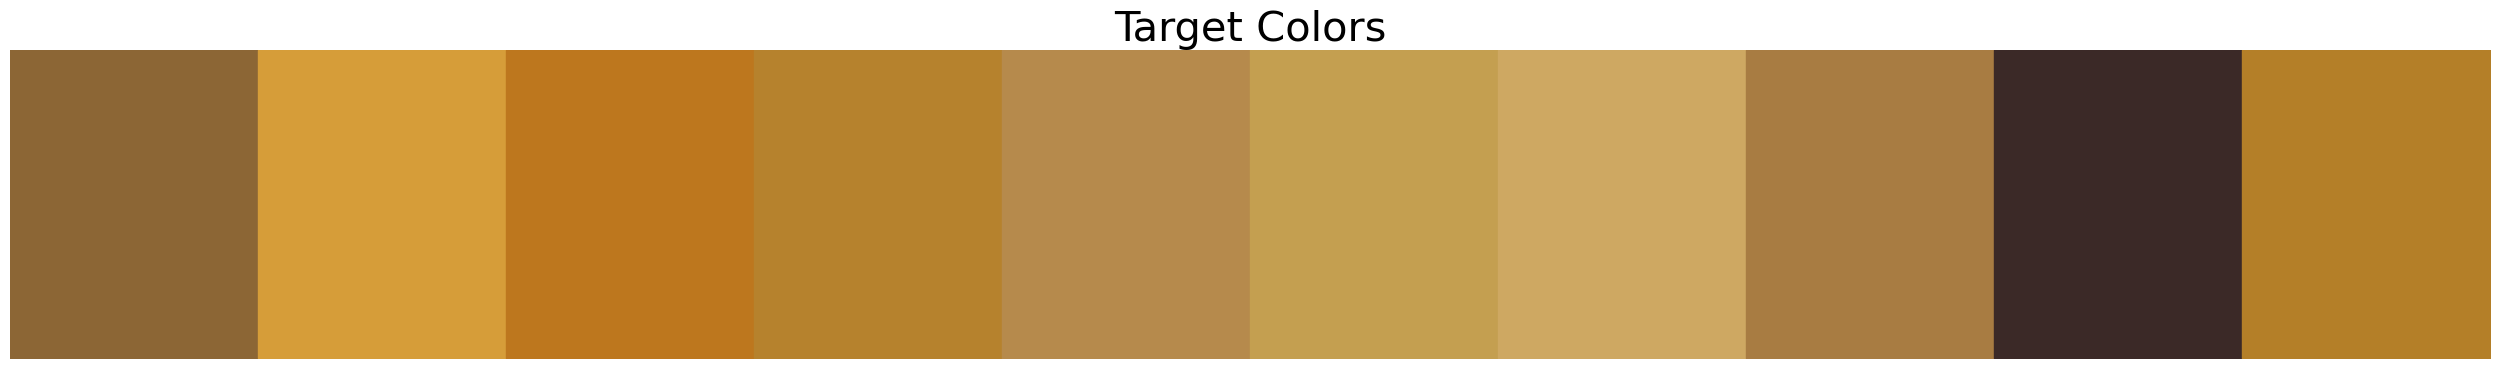

In [32]:
# Plot output and target color
plot_rgb_blocks(convert(target_colors_head_zoomed[0]), "Output Colors",max_colors = 10)
plot_rgb_blocks(convert(output_colors_head_zoomed[0]), "Target Colors",max_colors = 10)

In [49]:
loss_head_zoomed = calulate_MSE_loss(target_colors_head_zoomed,output_colors_head_zoomed)

print('Final validation loss Head', round(loss_head_zoomed.item() / len(target_colors_head_zoomed), 4))

Final validation loss Head 0.0061


### Segment model Abdomen

In [34]:
#Abdomen
file_path_target = "/Users/lisavind/Desktop/Model_zoomed/target_colors_abdomen.pkl"
target_colors_abdomen_zoomed = open_pickle(file_path_target)

file_path_output = "/Users/lisavind/Desktop/Model_zoomed/output_colors_abdomen.pkl"
output_colors_abdomen_zoomed = open_pickle(file_path_output)

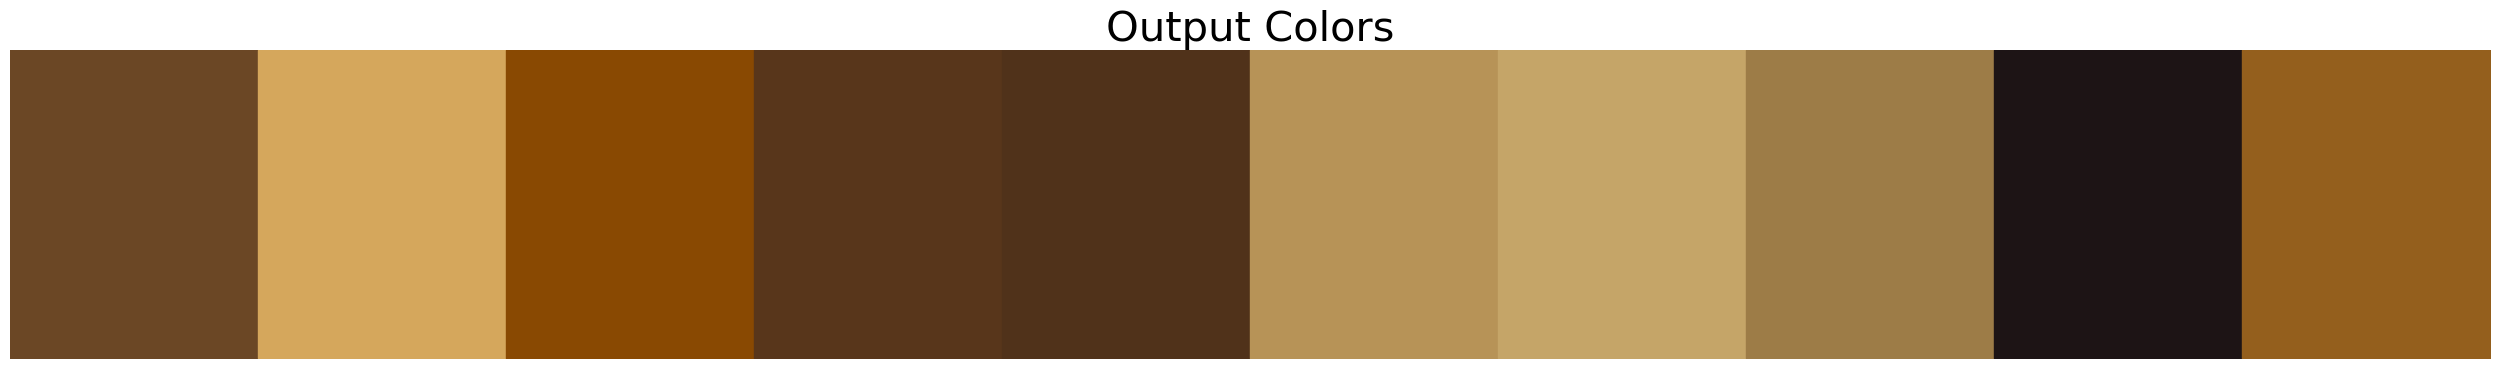

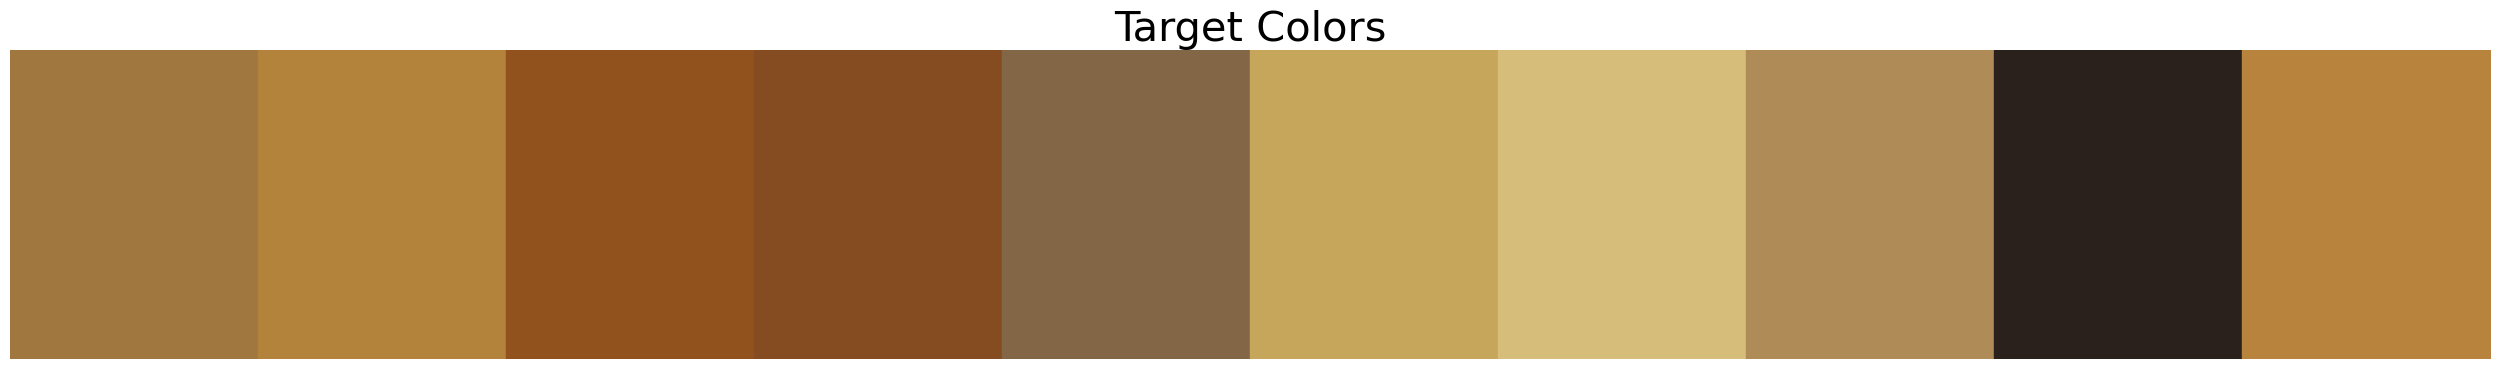

In [35]:
# Plot output and target color
plot_rgb_blocks(convert(target_colors_abdomen_zoomed[0]), "Output Colors",max_colors = 10)
plot_rgb_blocks(convert(output_colors_abdomen_zoomed[0]), "Target Colors",max_colors = 10)

In [48]:
loss_abdomen_zoomed = calulate_MSE_loss(target_colors_abdomen_zoomed,output_colors_abdomen_zoomed)

print('Final validation loss Abdomen', round(loss_abdomen_zoomed.item() / len(target_colors_abdomen_zoomed), 4))

Final validation loss Abdomen 0.0074


### Comparing Euclidian distance distribution using cropped images

In [37]:
target_colors_array_thorax_zoomed = convert_tensor_in_batch_to_numpy(target_colors_thorax_zoomed)
output_colors_array_thorax_zoomed = convert_tensor_in_batch_to_numpy(output_colors_thorax_zoomed)

euclidian_distance_thorax_zoomed = np.sum((target_colors_array_thorax_zoomed - output_colors_array_thorax_zoomed)** 2, axis = 1)

target_colors_array_head_zoomed = convert_tensor_in_batch_to_numpy(target_colors_head_zoomed)
output_colors_array_head_zoomed = convert_tensor_in_batch_to_numpy(output_colors_head_zoomed)

euclidian_distance_head_zoomed = np.sum((target_colors_array_head_zoomed - output_colors_array_head_zoomed)** 2, axis = 1)

target_colors_array_abdomen_zoomed = convert_tensor_in_batch_to_numpy(target_colors_abdomen_zoomed)
output_colors_array_abdomen_zoomed = convert_tensor_in_batch_to_numpy(output_colors_abdomen_zoomed)

euclidian_distance_abdomen_zoomed = np.sum((target_colors_array_abdomen_zoomed - output_colors_array_abdomen_zoomed)** 2, axis = 1)

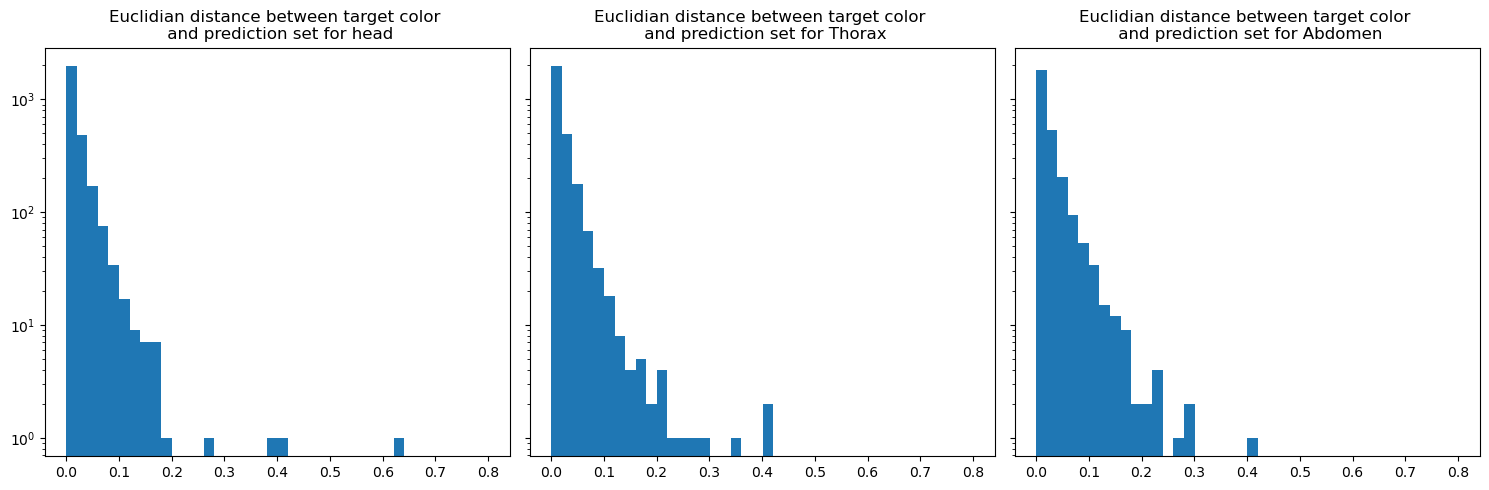

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)


# Plot for Head
axs[0].hist(euclidian_distance_head_zoomed, bins=bins)
axs[0].set_title('Euclidian distance between target color \n and prediction set for head')
axs[0].set_yscale('log')

# Plot for Thorax
axs[1].hist(euclidian_distance_thorax_zoomed, bins=bins)
axs[1].set_title('Euclidian distance between target color \n and prediction set for Thorax')
axs[1].set_yscale('log')

# Plot for Abdomen
axs[2].hist(euclidian_distance_abdomen_zoomed, bins=bins)
axs[2].set_title('Euclidian distance between target color \n and prediction set for Abdomen')
axs[2].set_yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()

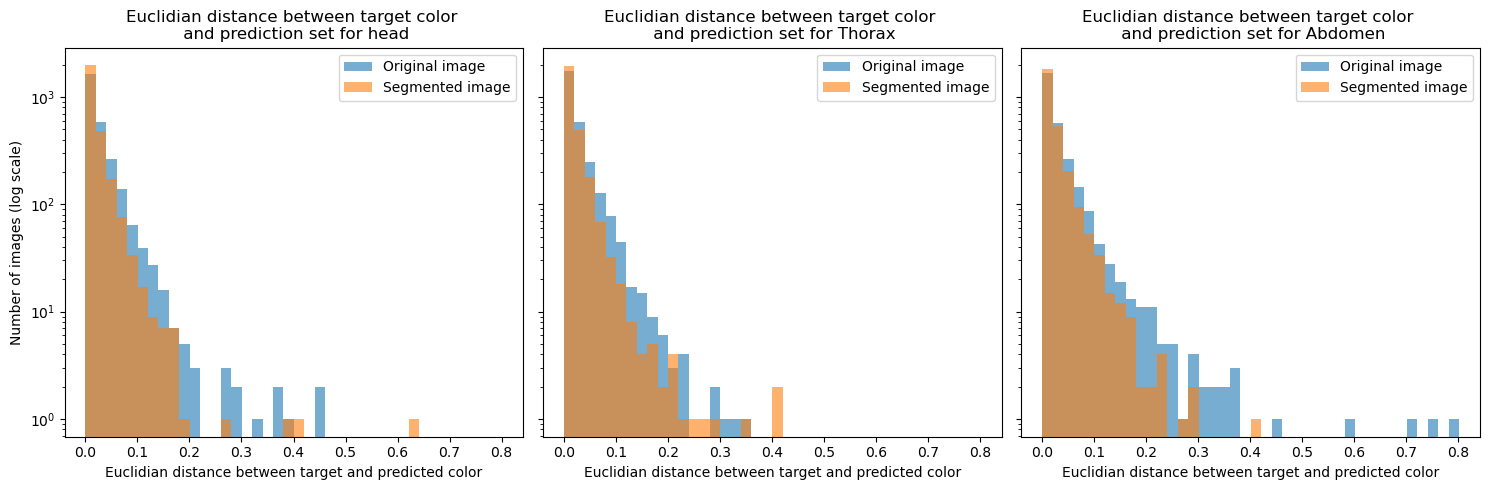

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Plot for Head
axs[0].hist(euclidian_distance_head, bins=bins, alpha=0.6, label='Original image')
axs[0].hist(euclidian_distance_head_zoomed, bins=bins, alpha=0.6, label='Segmented image')
axs[0].set_title('Euclidian distance between target color \n and prediction set for head')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_ylabel('Number of images (log scale)')
axs[0].set_xlabel('Euclidian distance between target and predicted color')

# Plot for Thorax
axs[1].hist(euclidian_distance_thorax, bins=bins, alpha=0.6, label='Original image')
axs[1].hist(euclidian_distance_thorax_zoomed, bins=bins, alpha=0.6, label='Segmented image')
axs[1].set_title('Euclidian distance between target color \n and prediction set for Thorax')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel('Euclidian distance between target and predicted color')

# Plot for Abdomen
axs[2].hist(euclidian_distance_abdomen, bins=bins, alpha=0.6, label='Original image')
axs[2].hist(euclidian_distance_abdomen_zoomed, bins=bins, alpha=0.6, label='Segmented image')
axs[2].set_title('Euclidian distance between target color \n and prediction set for Abdomen')
axs[2].set_yscale('log')
axs[2].legend()
axs[2].set_xlabel('Euclidian distance between target and predicted color')

# Adjust layout
plt.tight_layout()
plt.show()